In [14]:
import torch
import random
import numpy as np  # numpy
import torch.nn as nn  # nn objects
import torch.optim as optim  # nn optimizers
import matplotlib.pyplot as plt
%matplotlib notebook

## custom packages ##
from networkUtils import recurrentNet as rn
from taskUtils import generate as gen
from trainUtils import trainer as tn
from testUtils import test, plot

# Set device to gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Hyperparameters
input_size = 5
num_classes = 2  # the number of units in the output layer
hidden_size = 3  # the number of units in the recurrent layer
batch_size = 1  # batch size = # of samples to average when computing gradient
num_layers = 1  # number of stacked RNN layers
eta = 0.001  # learning rate
epochs = 500  # epochs = # of full pases through dataset
num_networks = 10 # number of networks to average when calculating loss

In [16]:
# Loss function, optimizer, and schedule (for decaying learning rate)
criterion = nn.CrossEntropyLoss()  # loss function

In [17]:
def get_loss(num_networks, condition, verbose=False):
    seqlen1, seqlen2, seqlen3 = condition[0], condition[1], condition[2]
    losses = []
    mean_loss = np.array([])
    seeds = []
    for i in range(num_networks):
        seed = rn.RecurrentXORNet(input_size, hidden_size, num_layers, num_classes, batch_size, random_h0=True).to(device)
        optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
        sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
        dataset, targets, sequence_length = gen.generate_dataset(False, input_size, seqlen1, seqlen2, seqlen3)
        loss = tn.train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, verbose)
        if i == 0:
            mean_loss = loss
        else:
            mean_loss = mean_loss + loss
        seeds.append(seed)
        losses.append(loss)
    losses = np.array(losses)
    mean_loss = mean_loss/num_networks
    return mean_loss, losses, seeds

In [18]:
small_middle = [0, 1, 0] # small train in the middle
large_middle = [0, 150, 0] # large train in the middle

In [19]:
mean_loss_1,losses_1,_ = get_loss(num_networks, small_middle)
mean_loss_2,losses_2,_ = get_loss(num_networks, large_middle)

<IPython.core.display.Javascript object>


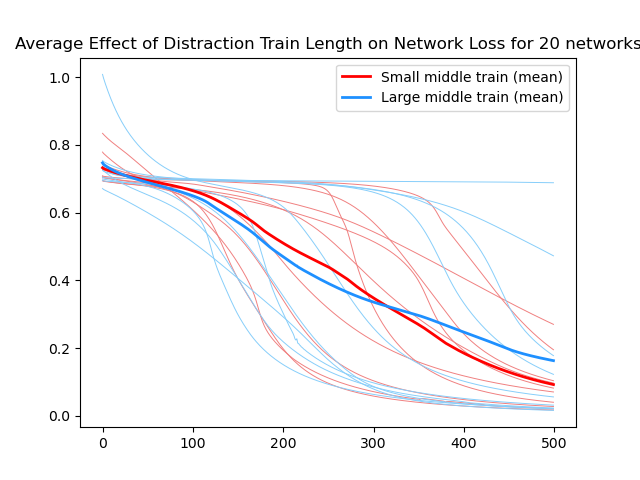

In [20]:
# plot losses
plt.title("Average Effect of Distraction Train Length on Network Loss for 20 networks")
plot.plot_individual_losses(losses_1, color='lightcoral', linewidth=0.7)
plot.plot_individual_losses(losses_2, color='lightskyblue', linewidth=0.7)
plt.plot(mean_loss_1, color='red', label="Small middle train (mean)", linewidth=2)
plt.plot(mean_loss_2, color='dodgerblue', label="Large middle train (mean)", linewidth=2)
plt.legend() # by default, the legend ignores all elements without a label attribute set.
plt.show()